# Multi-atlas Segmentation

In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial

%matplotlib inline

/home/okozyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import Helper Functions

In [2]:
%run "./src/nib_tools.py"
%run "./src/file_tools.py"
%run "./src/em.py"

## Find Weights from Mutual Information

In [38]:
# Path to test image
# possible values 
data_reg_params = ["Par0000-no-matching", "Par0009-no-matching", "Par0009-matched-to-mni"]
# regular majority voting or weighted voting multi-atlas
modes = ['ma', 'weighted_ma']
data_reg_param = data_reg_params[2]
mode = modes[1]

valid_img_path = f"./registered-data/{data_reg_param}/Validation_Set/templates/"
gt_path = f"./registered-data/{data_reg_param}/Validation_Set/labels/"
train_labels_path = f"./registered-data/{data_reg_param}/Training_Set/labels/"
train_img_path = f"./registered-data/{data_reg_param}/Training_Set/templates/"

train_dirs = [f for f in listdir(train_img_path) if isdir(join(train_img_path, f))]
valid_dirs = [f for f in listdir(valid_img_path) if isdir(join(valid_img_path, f))]

# read training labels
train_labels = []
for f in train_dirs:
    labels, _ = read_im(join(train_labels_path, f, 'result.nii.gz'))
    train_labels.append(labels)

print(train_dirs)
print(valid_dirs)

['IBSR_18', 'IBSR_03', 'IBSR_01', 'IBSR_06', 'IBSR_09', 'IBSR_07', 'IBSR_16', 'IBSR_08', 'IBSR_05', 'IBSR_04']
['IBSR_13', 'IBSR_12', 'IBSR_17', 'IBSR_11', 'IBSR_14']


In [39]:
def get_sim_metrics(train_dir_path):
    """
    Get similarity metrics from elastix log files.
    
    Args:
        train_dir_path (str): the path to a folder with registration results.
    
    Returns:
        (numpy.ndarray): similarity metrics.
    """
    import re
    
    dirs = tuple(f for f in listdir(train_dir_path) if isdir(join(train_dir_path, f)))
    sim_metrics = np.zeros(len(dirs))
    
    for index, train_dir in enumerate(dirs):
        elastix_log_file = open(join(train_dir_path, train_dir, 'elastix.log'), "r")
        elastix_log = elastix_log_file.read()
        elastix_log_file.close()
        reg_expr = r'^Final metric value\s+=\s+([\d\.\-]+)$'
        
        matches = re.findall(reg_expr, elastix_log, re.M)
        
        # 0th value - MI after affine transformation, 1st value - MI after B-splines transformation
        sim_metrics[index] = matches[1]
        
    return sim_metrics


def majority_vote_masks(train_labels, weights=None):
    """
    Get segmentation masks for CSF, GM, WM tissues.
    
    Args:
        train_labels ([numpy.ndarray]): an iterable of training labels (ground-truth segmentations).
        weights ([float]): an iterable with weights for each label, should have the same length
            as train_labels, optional.
    
    Returns:
        csf_mask, gm_mask, wm_mask (tuple(numpy.ndarray)): a tuple of masks for tissue segmentation.
    """
    csf_mask = None
    gm_mask = None
    wm_mask = None
    
    if weights is None:
        weights = np.ones(len(train_labels))

    for labels, w in zip(train_labels, weights):
        csf_vote = np.zeros_like(labels, dtype=float)
        gm_vote = np.zeros_like(labels, dtype=float)
        wm_vote = np.zeros_like(labels, dtype=float)

        csf_vote[labels == CSF_label] = w
        gm_vote[labels == GM_label] = w
        wm_vote[labels == WM_label] = w

        if (csf_mask is None) and (gm_mask is None) and (wm_mask is None):
            csf_mask = csf_vote
            gm_mask = gm_vote
            wm_mask = wm_vote
        else:
            csf_mask += csf_vote
            gm_mask += gm_vote
            wm_mask += wm_vote
    
    return csf_mask, gm_mask, wm_mask

In [40]:
if mode == 'ma':
    maj_vote_csf_mask, maj_vote_gm_mask, maj_vote_wm_mask = majority_vote_masks(train_labels)
elif mode == 'weighted_ma':
    sim_metrics = get_sim_metrics(train_img_path)
    sim_metrics = -1 * sim_metrics
    maj_vote_csf_mask, maj_vote_gm_mask, maj_vote_wm_mask = majority_vote_masks(train_labels, weights=sim_metrics)

CSF_atlas = normalize(maj_vote_csf_mask, max_val=1.0)
GM_atlas = normalize(maj_vote_gm_mask, max_val=1.0)
WM_atlas = normalize(maj_vote_wm_mask, max_val=1.0)

## Atlas and Histogram

In [37]:
max_intens = 255
# Path to test image
test_img_path = valid_img_path

# Path to atlas image folder
result_path = f"./segmentation-results/{data_reg_param}/hist-segmentation-{mode}/"
out_dice_path = f'./dice-results/{data_reg_param}_hist_dice-{mode}.csv'
os.mkdir(result_path)

    
def get_hist_probs(img, hist):
    """Returns probability values for an image based on a given histogram.
    
    Parameters:
        img (np.ndarray): input image.
        hist (np.ndarray): histogram.
    
    Returns:
        out_prob (np.ndarray): propability image.
    """
    out_prob = np.zeros_like(img, dtype='float')
    # we assume that intensity values and indices of bins correspond
    for intens_val in np.nditer(np.nonzero(hist)):
        out_prob[img == intens_val] = hist[intens_val]
    
    return out_prob

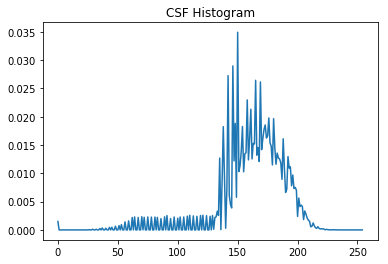

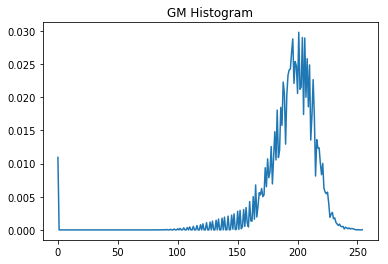

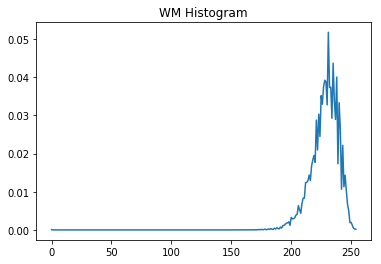

In [38]:
im_names = [f for f in listdir(train_img_path) if isdir(join(train_img_path, f))]

# Initialize arrays to hold intensity values 
# CSF_intensities, WM_intensities, GM_intensities
for i, f in enumerate(im_names):
    # Load all data for histogram
    test_data, test_img = read_im(join(train_img_path,f,'result.1.nii.gz'))
    test_data = normalize(test_data, max_intens)
    test_data = test_data.astype(int)
    labels_data, labels_img = read_im(join(train_labels_path,f,'result.nii.gz'))

    if i == 0:
        # Initialize arrays to hold intensity values 
        CSF_intensities = test_data[labels_data == CSF_label]
        WM_intensities = test_data[labels_data == WM_label]
        GM_intensities = test_data[labels_data == GM_label]
    else:    
        CSF_intensities = np.append(CSF_intensities, test_data[labels_data == CSF_label])
        WM_intensities = np.append(WM_intensities, test_data[labels_data == WM_label])
        GM_intensities = np.append(GM_intensities, test_data[labels_data == GM_label])

# get histograms
bins = tuple(range(0, max_intens+1))
CSF_hist, _ = np.histogram(CSF_intensities, bins, density=True)
GM_hist, _ = np.histogram(GM_intensities, bins, density=True)
WM_hist, _ = np.histogram(WM_intensities, bins, density=True)
bins = bins[:-1]

# plot histograms
plt.plot(bins, CSF_hist)
plt.title("CSF Histogram")
plt.show()

plt.plot(bins, GM_hist)
plt.title("GM Histogram")
plt.show()

plt.plot(bins, WM_hist)
plt.title("WM Histogram")
plt.show()

In [42]:
onlydirs = [f for f in listdir(test_img_path) if isdir(join(test_img_path, f))]

all_dice = np.zeros((len(onlydirs),3))

for i, f in enumerate(onlydirs):
    test_data, template_img = read_im(join(test_img_path,f,'result.1.nii.gz'))
    test_data = normalize(test_data, max_intens)
    test_data = test_data.astype(int)

    # Incorporate historgram from above
    # compute probabilities based on intensity histograms
    GM_hist_prob = get_hist_probs(test_data, GM_hist)
    WM_hist_prob = get_hist_probs(test_data, WM_hist)
    CSF_hist_prob = get_hist_probs(test_data, CSF_hist)

#     # combine those probabilities
    GM_hist_prob *= GM_atlas
    WM_hist_prob *= WM_atlas
    CSF_hist_prob *= CSF_atlas

    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((GM_hist_prob >= CSF_hist_prob) * (GM_hist_prob > WM_hist_prob))
    WM = WM_label * np.nan_to_num((WM_hist_prob > CSF_hist_prob) * (WM_hist_prob >= GM_hist_prob))
    CSF = CSF_label * np.nan_to_num((CSF_hist_prob >= WM_hist_prob) * (CSF_hist_prob > GM_hist_prob))
    seg_im = GM + WM + CSF
    segmented_img = nib.Nifti1Image(seg_im, template_img.affine, template_img.header)

    # Calculate DICE
    path_gt = join(gt_path,f,"result.nii.gz")
    _, groundtruth_img = read_im(path_gt)
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segmented_img, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    os.mkdir(new_dir)
    nib.save(segmented_img, join(new_dir,'atlas_hist_seg.nii.gz'))

print(all_dice)
save_dice(out_dice_path, onlydirs, all_dice)

[[0.00645166 0.86087093 0.88426861]
 [0.00759505 0.82048081 0.91323972]
 [0.00737433 0.86640086 0.84344791]
 [0.00669433 0.8148916  0.90650847]
 [0.00659111 0.85316495 0.90482051]]


## EM+Multi-atlas

In [41]:
max_intens = 255

MAX_STEPS = 30
min_change = 0.01

test_img_path = valid_img_path

In [42]:
# Path to atlas image folder
result_path = f"./segmentation-results/{data_reg_param}/em-segmentation-{mode}/"
out_dice_path = f'./dice-results/{data_reg_param}_em_dice-{mode}.csv'
os.mkdir(result_path)

onlydirs = [f for f in listdir(test_img_path) if isdir(join(test_img_path, f))]

all_dice = np.zeros((len(onlydirs),3))

GM_atlas_flat = GM_atlas.flatten()
WM_atlas_flat = WM_atlas.flatten()
CSF_atlas_flat = CSF_atlas.flatten()
mask = GM_atlas + WM_atlas + CSF_atlas
mask_data = mask.copy().flatten()
mask_data = np.transpose(mask_data)

for i, f in enumerate(onlydirs):
    # Load all data for EM algorithm
    test_data, test_img = read_im(join(test_img_path, f, 'result.1.nii.gz'))
    test_data = normalize(test_data, max_intens)

    _, groundtruth_img = read_im(join(gt_path, f, "result.nii.gz"))

    # Pre-process feature vector to remove background points from algorithm
    # and save those indicies to add back
    features = test_data.copy().flatten()
    features = np.transpose(features)   

    features_nonzero_row_indicies = np.nonzero(mask_data)
    features_nonzero = features[features_nonzero_row_indicies]

    # row index shifted by +1 will correspond to tissue labels from ground-truth
    features_nonzero_pred = np.array((CSF_atlas_flat[features_nonzero_row_indicies],
                                      WM_atlas_flat[features_nonzero_row_indicies],
                                      GM_atlas_flat[features_nonzero_row_indicies]))
    y_pred = np.argmax(features_nonzero_pred, axis=0)

    # intialize EM algorithm
    class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0]]
    class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0]]
    class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0]]

    # Compute mean and variance of each class
    mean0 = np.mean(class0, axis = 0)
    mean1 = np.mean(class1, axis = 0)
    mean2 = np.mean(class2, axis = 0)
    cov0 = np.cov(class0, rowvar = False)
    cov1 = np.cov(class1, rowvar = False)
    cov2 = np.cov(class2, rowvar = False)

    # Class distribution
    a0 = class0.shape[0] / features_nonzero.shape[0]
    a1 = class1.shape[0] / features_nonzero.shape[0]
    a2 = class2.shape[0] / features_nonzero.shape[0]

    # Compute Gaussian mixture model for each point
    p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
    p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
    p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

    # # Compute membership weight for each point
    weights = membership_weight(p0, p1, p2, a0, a1, a2)
    # get initial log-likelihood
    log_likelihood = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

    n_steps = 0

    while True:
        # Maximization step: Use that classification to reestimate the parameters
        # Class distribution
        counts = np.sum(weights, axis=0)

        a0 = counts[0] / len(features_nonzero)
        a1 = counts[1] / len(features_nonzero)
        a2 = counts[2] / len(features_nonzero)

        # Calculate mean and covariance for new classes
        mean0 = (1/counts[0]) * (weights[:, 0] @ features_nonzero)
        mean1 = (1/counts[1]) * (weights[:, 1] @ features_nonzero)
        mean2 = (1/counts[2]) * (weights[:, 2] @ features_nonzero)
        cov0 = (1/counts[0]) * ((weights[:, 0] * (features_nonzero - mean0)) @ (features_nonzero - mean0))
        cov1 = (1/counts[1]) * ((weights[:, 1] * (features_nonzero - mean1)) @ (features_nonzero - mean1))
        cov2 = (1/counts[2]) * ((weights[:, 2] * (features_nonzero - mean2)) @ (features_nonzero - mean2))

        p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
        p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
        p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

        # Compute membership weight for each point
        weights = membership_weight(p0, p1, p2, a0, a1, a2)

        log_likelihood_new = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

        dist_change = abs((log_likelihood_new - log_likelihood) / log_likelihood)
        print("********************************************************************")
        print(f"Img {f}")
        print("Step %d" % n_steps)
        print("Distribution change %f" % dist_change)
        print(a0, a1, a2)

        n_steps += 1

        # check whether we reached desired precision or max number of steps
        if (n_steps >= MAX_STEPS) or (dist_change <= min_change):
            print("Loop stopped")
            break
        else:
            log_likelihood = log_likelihood_new

    y_pred = np.argmax(weights, axis=1)
    segment_nii_atlas = integrate_atlas_nii(test_img, y_pred, features_nonzero, 
                               features_nonzero_row_indicies, weights, CSF_atlas, 
                               GM_atlas, WM_atlas)

    # Calculate DICE
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segment_nii_atlas, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    os.mkdir(new_dir)
    nib.save(segment_nii_atlas, join(new_dir,'atlas_EM_seg.nii.gz'))

save_dice(out_dice_path, onlydirs, all_dice)

********************************************************************
Img IBSR_13
Step 0
Distribution change 0.024996
0.012556190401469932 0.4278967961723343 0.5595470134275692
********************************************************************
Img IBSR_13
Step 1
Distribution change 0.017117
0.01827542243853811 0.5545719221530978 0.42715265541056857
********************************************************************
Img IBSR_13
Step 2
Distribution change 0.013447
0.025327047015467705 0.6650385969910686 0.3096343559931032
********************************************************************
Img IBSR_13
Step 3
Distribution change 0.009361
0.03206923027510006 0.7473947925124103 0.22053597721336268
Loop stopped
********************************************************************
Img IBSR_12
Step 0
Distribution change 0.024839
0.008925981622190762 0.451526745222123 0.5395472731608357
********************************************************************
Img IBSR_12
Step 1
Distribution change 

In [43]:
print(all_dice)

[[0.73815124 0.8157114  0.80473421]
 [0.85011393 0.78033749 0.82912281]
 [0.86132058 0.79138092 0.80600781]
 [0.86190173 0.76952285 0.82103951]
 [0.79405735 0.80653402 0.82950308]]
